<a href="https://colab.research.google.com/github/paruliansaragi/Notebooks/blob/master/cs231n_A1_cont.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://cs231n.github.io/neural-networks-1/

#Neural Nets 1

As before, a linear classifier would compute scores $s = Wx$, in NN's we compute $s = W_2max(0, W_1x)$. Here $W_1$ could be a 100x3072 matrix transforming the image into 100-D intermediate vector. The max function introduces non-linearity element wise thresholding at 0. $W_2$ then would be 10x100 and we get 10 class scores. Non-linearity is crucial-if we left it out, the two matrices could be collapsed into 1, and the class scores would just be a linear function of the input. Parameters are learned with SGD, and gradients derived with chain rule computed with backprop. 

##Modeling one neuron

```
class Neuron(object):
def forward(self, x):
cell_body_sum = np.sum(x * self.weights) + self.bias
firing_rate = 1.0 / (1.0 + math.exp(-cell_body_sum))#sigmoid
return firing_rate
```
Each neuron performs a dot product with the input and its weights then non-linearity. 

##Single neuron as a linear classifier

A neuron has the ability to like (activation near one) or dislike (activation near 0) certain linear regions of its input space. With an appropriate loss we can turn a single neuron into a linear classifier.

**Binary softmax classifier**: for instance, we can interpret $\sigma(\sum_iw_ix_i + b)$ to be the probability of one of the classes $P(y_i = 1 \mid x_i; w)$. The probability of other class would be $P(y_i = 0 \mid x_i; w) = 1 - P(y_i = 1 \mid x_i; w)$, since they must sum to one. We can formulate the cross-entropy loss and optimizing would lead to binary softmax classifier (logistic regression). Since sigmoid restricts values between 0-1, the predictions are based on whether the output of the neuron is greater than 0.5. 

We could attach a max-margin hinge loss to the output and train it to be a binary SVM classifier. 

##Commonly used activation functions

Every activation function (non-linearity) takes a single number and performs a fixed-mathematical operation on it. 

Sigmoid: this function has the form $\sigma(x) = 1 / (1 + e^{-x})$. ![alt text](http://cs231n.github.io/assets/nn1/sigmoid.jpeg)
It squishes numbers between 0 and 1. Large negatives or positives become 0 and 1 respectively. Sigmoid is not used because:
- sigmoids saturate and kill gradients: one property is that when the neuron's activation saturates at either tail of 0 or 1, the gradient at these regions is almost 0. Recall in backprop the local gradient will be multiplied to the gradient of this gate's output. If the local gradient is very small, it will kill the gradient and almost no signal will flow through the neuron to its weights and to its data. You have to be careful initializing the weights of sigmoid to prevent saturation, if too large then most neurons will become saturated and the NN won't learn. 
- Sigmoid outputs are not zero-centered: this is not good since neurons in the later layers of would receive data that is not zero-centered. If the data coming into a neuron is always positive e.g. x > 0 elementwise in $f = w^Tx + b$, then the gradient on the weights w will during backprop become either all positive or all negative. This could introduce undesirable zig-zagging in the gradient updates for the weights. However, once these gradients are added up across a batch of data the final update for the weights can have variable signs mitigating the issue. Inconvenient but less severe.

Tanh: It squishes between -1, 1, its outputs saturate but are not zero centered. It is prefered to over sigmoid, it is simply a scaled sigmoid, $\tanh(x) = 2 \sigma(2x) -1$. 

Relu: it computes $f(x) = \max(0, x)$ and is simply a threshold at 0. Pro's and cons:
- (+) It greatly accelerated convergence of SGD compared with tahnh/sigmoid, due to its linear, non-saturating form. 
- (+) Compared to tanh/sigmoid that involve expensive ops like exp, ReLU can be implemented simply by thresholding a matrix of activations at 0. 
- (-) ReLU units are fragile during training and can die. For example, a large gradient flowing through a ReLU neuron could cause the weights to update in such a way that the neuron will never activate on any datapoint again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. That is ReLU can irreversibly die as they can get knocked off the data manifold. For instance, if the learning rate is too high as much as 40% can be dead.

Leaky ReLU: They fix the dying ReLU problem. Instead of the function being 0 when x < 0, a leaky ReLU instead has a small negative slope of 0.01. The function computes $f(x) = \mathbb{1}(x < 0) (\alpha x) + \mathbb{1}(x>=0) (x)$ where $\alpha$ is a small constant. 

Maxout: This generalizes the ReLU and its leaky version. It computes the function $\max(w_1^Tx+b_1, w_2^Tx + b_2)$. It enjoys all the benefits of ReLU (linear regime of operation and no saturation) and not its drawbacks (dying relu). It does double the number of parameters for every single neuron increasing total parameters. 

##NN architectures
###Layer-wise organisation
NN's are neurons in graphs. They are collections of neurons connected in a acyclic graph. Meaning, outputs of some neurons can become inputs to other neurons. Cycles are not allowed since that would imply an infinite loop in forward propagation. NN are organised into layers of neurons. Neurons between 2 adjacent layers are fully pairwise connected but neurons within a distinct layer share no connections. 

##Example Feed-Forward Computation
Repeated matrix multiplications interwoven with activation function. Working with an example 3-layer NN, the input say 3x1 vector. All connection strengths are stored in a single matrix. E.g., the first hidden layer's weights W1 would be of size 4x3, and biases vector b1 4x1. Every neuron has its weights in W1, so the matrix vector multiplication np.dot(W1, x) evaluates the activations of all neurons in that layer. 

```
f = lambda x: 1.0/(1.0 + np.exp(-x))#activation function (sigmoid)
x = np.random.randn(3,1)
h1 = f(np.dot(W1, x) + b1)
h2 = f(np.dot(W1, h1) + b2)
out = np.dot(W3, h2) + b3
```

Note that instead of having a single input column vector, the variable x could hold the entire batch of training data (where each input example could be a column in x) and then all examples would be efficiently evaluated in parallel. 

##Representational Power
One way to look at NN's is that they define a family of functions that are parameterized by the weights of the network. What is the representational power of this family of funcs? Are there funcs that cant be modeled with a NN?

It turns out that NN's with at least one hidden layer are universal approximators. Given any continuous function f(x) and some $\epsilon > 0$, there exists a Neural Network g(x) with one hidden layer (with reasonable choice of non-linearity e.g. sigmoid) such that  for all x's, $\forall x, \mid f(x) - g(x) \mid < \epsilon$. The NN can approximate any continuous function. 

If one hidden layer suffices to approximate any function why use more and go deeper? The answer is that while a two-layer NN is a universal approximator it is a weak statement in practice. In 1-D, the sum of indicator bumps function $g(x) = \sum_i c_i \mathbb{1}(a_i < x < b_i)$ where a,b,c are param vectors is also a universal approximator but noone would suggest to use this functional form in ML. NN's work well in practice because they express nice smooth functions that fit well with statistical properties of data we encounter, and are easy to learn using optimization algorithms. Deeper nets work better than single hidden layer nets is an empirical observation, despite the fact their representational power is equal. Often the case 3 > 2 layers but deeper rarely helps. Unlike CNNs where going deeper works. One argument is that images contain hierarchical structure so several layers of processing makes sense. 

##Setting Number of layers and their sizes

As we increase the size and number of layers in a NN, the capacity of the network increases. That is the sapce of representable functions grows since neurons can collaborate to express many different functions. Larger nets can represent more complicated functions. ![alt text](http://cs231n.github.io/assets/nn1/layer_sizes.jpeg)

Although it can express more complexity it leads to overfitting. Overfitting occurs when a model with high capacity fits the noise in the data instead of the underlying relationship. In the above the 20 hidden neurons fit all training data points but it segments the space into many disjoint decision regions. Conversly, the 3 hidden model lacks representational power. This models the data as two blobs and interprets a few outliers (noise) in the green blob which may lead to better generalization on the test set. 

Smaller nets may appear better but it is almost always better to overfit and regularize. The reason being that the smaller nets are harder to train with local methods such as gradient descent: it's clear their loss functions have few local minima, but that many of these minima are easier to converge to, and they are bad (with high loss). Conversly, bigger nets contain more local minima but they have much better loss. Since NN are non-convex it's hard to study these properties mathematically. In practice, you find that if you train a small net the final loss can display a good amount of variance. If you train a large net you'll start to find many different solutions, but the variance in the final achieved loss will be much smaller. 

![alt text](http://cs231n.github.io/assets/nn1/reg_strengths.jpeg) 

Effects of regularisation: changing regularization strength makes the nets final decision regions smoother with higher regularisation.



http://cs231n.github.io/neural-networks-2/

#Neural Networks 2

##Data Preprocessing
There are 3 common forms of data preprocessing of a data matrix X where X is NxD where N is number of data, D is their dimensionality.

**Mean subtraction**: most common, involves subtracting the mean across every individual feature in the data, and has the geometric interpretation of centering the cloud of data around the origin along every dimension. In numpy this is done as: X -= np.mean(X, axis=0). With images for convenience it can be common to subtract a single value from all pixels e.g. X -= np.mean(X) or to do so separately across the three color channels. 

**Normalization** normalizing data dimensions so they are similar scale. 2 common ways: One is to divide each dimension by its standard deviation, once it has been zero-centered: X /= np.std(X, axis=0). Another form of this preprocessing normalizes each dimension so that the min and max along the dimension is -1 and 1. 

![alt text](http://cs231n.github.io/assets/nn2/prepro1.jpeg)

Middle: zero-centered subtracting mean in each dimension. The data cloud is centered around the origin. Right: Each dimension is scaled by its standard deviation. The red lines indicate the extent of the data - they are of unequal length in the middle, but of equal length on the right.

**PCA and whitening**: data is first centered. Then, we can compute the covariance matrix that tells us the correlation structure in the data:
```
x -= np.mean(X, axis=0)#zero-center data
cov = np.dot(X.T, X) / X.shape[0] #get the data covariance matrix
```
The i,j element contains the covariance between the i-th, j-th dimension of the data. The diagonal of this matrix contains the variances. The covariance matrix is symmetric and positive semi-definite (symmetric matrix M is said to be positive definite if the scalar $z^{T}Mz$ is strictly positive for every non-zero column vector of $z$. $Mz$ = output of M that is acting on input $z$ implying the output always has a positive inner product with the input). We can compute the SVD factorization of the data covariance matrix: 
```
U, S, V = np.linalg.svd(cov)
```
where the columns of U are the eigenvectors and S is a 1-D array of singular values. To decorrelate the data, we project the original but zero-centered data into the eigenbasis: 
```
Xrot = np.dot(X, U)#decorrelate
```
Notice the columns of U are a set of orthonormal vectors (norm 1, and orthogonal to each other), so they can be regarded as basis vectors. The projection thus corresponds to a rotation of the data in X so that the new axes are the eigenvectors. If we compute the covariance matrix of Xrot we see its now diagonal. np.linalg.svd returns the value U, with the eigenvector columns sorted by their eigenvalues. We can use this to reduce the dimensionality of the data by only using the top few eigenvectors, and discarding the dimensions along which the data has no variance (keep the principal components that gave the most information). This is sometimes referred to as PCA: 
```
Xrot_reduced = np.dpt(X, Y[:, :100])#Xrot_reduced becomes N x 100
```
We have now reduced the dataset of size N x D to one of N x 100 keeping 100 dims of the data that contain the most variance. It's often the case you get good performance by training NN's on PCA-reduced datasets saving time and space.

**Whitening**: takes the data in the eigenbasis and divides every dimension by the eigenvalue to normalize the scale. The geometric interpretation of this transformation is that if the input data is a multivariable gaussian, then the whitened data will be a gaussian with zero mean and identity covariance matrix. This goes:
```
#whiten data: divide by eigenvalues which are the square roots of the singular values
Xwhite = Xrot / np.sqrt(S + 1e-5)
```
Warning: Exaggerating noise: note we're adding a small constant 1e-5 to prevent division by zero. One weakness of this transformation is it can exaggerate noise in the data, since it stretches all dimensions (including irrelevant dims of tiny variance that are mostly noise) to be of equal size in the input. This can be mitigated by stronger smoothing i.e. increasing 1e-5. 

![alt text](http://cs231n.github.io/assets/nn2/prepro2.jpeg)

PCA/whitening. **Middle**: after PCA, the data is centered at 0 and then rotated into the eigenbasis of the data covariance matrix. This decorrelates the data (covariance matrix becomes diagonal). **Right**: Each dim is additionally scaled by the eigenvalues, transforming the data covariance matrix into the identity matrix. Geometrically, this corresponds to stretching and squeezing the data into an isotropic gaussian blob.

Lets visualise this with Cifar-10 (50,000 images of 3072 stretched row vectors). We can then compute the 3072 x 3072 covariance matrix and compute its SVD decomposition. 

![alt text](http://cs231n.github.io/assets/nn2/cifar10pca.jpeg)

The second from left, shows the top 144 out of 3072 eigenvectors. The top eigenvectors account for most of the variance in the data, and we can see that they correspond to lower frequencies in the images. The second from right, shows 49 images reduced with PCA, using the 144 eigenvectors. Instead of a 3072 vector where each element is the brightness of a pixel. This represents every image wit a 144-D vector where each element measures how much each eigenvector adds up to make an image. To visualize what image information has been retained by 144 vector, we must rotate back into the pixel basis of 3072 numbers. Since U is a rotation, this can be achieved by multiplying by U.transpose()[:144], then visualizing the resulting 3072 numbers as the image. They are blurry reflecting the fact that the top eigenvectors capture lower frequencies. Most of the info is still preserved. Right: visualization of white representation, where the variance along every one of 144-D is squashed to equal length. The 144 numbers are rotated back by multiplying U.transpose()[:144]. The lower frequencies which accounted for most variance are now negligible, while higher frequencies which account for little variance become exaggerated.

The data mean must be computed on the training data, then applied to the validation / test data. E.g. compute the mean and subtract from every image across entire dataset then split into train/val/test would be a mistake, the mean must be computed only over training then subracted equally from all splits (train/val/test).

##Weight Initialization

**Pitfall: all zero initialization:** This is a bad idea, because if every neuron in the net computes the same output, then they will compute the same gradients during backprop and undergo the same parameter updates. There is no asymmetry between neurons if their weights are initialized to be the same. 

**Small random numbers**. We still want weights to be close to zero since with data norm it is reasonable to assume that approximately half the weights will be positive and half negative. It is common to init weights of neurons to small numbers called symmetry breaking. The idea being the neurons are all random and unique in the beginning, so they will compute distinct updates. This might look like: ``` W = 0.01*np.random.randn(D,H)``` where randn samples from a zero mean, unit standard deviation gaussian. The weights are init as a random vector sampled from a multi-dimensional gaussian, so the neurons point in random directions in the input space. NB: not always the case small numbers work better, as this produces small gradients during backprop, since the gradient is proportional to the value of the weights. This could diminish the gradient signal flowing back. 

**Calibrating the variances with 1/sqrt(n)**. One problem with above method is the distribution of outputs from a randomly initialized neuron has a variance that grows with number of inputs. We can normalize the variances of each neuron's output to 1 by scling its weight vector by the square root of its fan-in (number of inputs). ```w = np.random.randn(n)/sqrt(n) #n num of inputs```. This improves rate of convergence and ensures the output distribution is approx the same for all neurons. 

The derivation is as follows: consider the inner product $s = \sum_i^n w_i x_i$ between the weigths and input w,x which gives the activation pre non-linearity.  
$\begin{align}
\text{Var}(s) &= \text{Var}(\sum_i^n w_ix_i) \\\\
&= \sum_i^n \text{Var}(w_ix_i) \\\\
&= \sum_i^n [E(w_i)]^2\text{Var}(x_i) + E[(x_i)]^2\text{Var}(w_i) + \text{Var}(x_i)\text{Var}(w_i) \\\\
&= \sum_i^n \text{Var}(x_i)\text{Var}(w_i) \\\\
&= \left( n \text{Var}(w) \right) \text{Var}(x)
\end{align}$

NB: variance is the expectation of the squared deviation of a random variable from its mean. The spread of a set of random numbers are spread out from their average value. The variance is the square of the standard deviation and the covariance (measure of the joint variability of two random vars. If the greater values of one var mainly correspond with greater values of the other then the covariance is positive) of the random variable with itself. 

The first two steps are the properties of variance. In the third step, we assumed zero mean inputs and weights, so $E[x_i] = E[w_i] = 0$. We assumed all $w_i,x_i$ are identically distributed. From this, we see we want s to have the same variance as x, then during initialization we ensure the variance of every weight w is $1/n$. Since $\text{Var}(aX) = a^2\text{Var}(X)$ for a random variable $X$ and a scalar a, this implies we should draw from unit gaussian and scale it by $a = \sqrt{1/n}$, to make sure its variance $1/n$. This gives initialization ``` w = np.random.randn(n) / sqrt(n)```.

The study Understanding the difficult of training deep FF NN by Glorot et al. recommend an initialization of the form $\text{Var}(w) = 2/(n_{in} + n_{out})$ where $n_{in},n_{out}$ are the number of units in the prev layer and next layer. A recent paper (Delving Deep into Rectifiers) by He et al., derives an initialization for ReLU neurons, concluding the variance of neurons in the network $2.0/n$. THis gives ```w = np.random.randn(n) * sqrt(2.0/n) ```, and is current recommendation for use in practice in specific case of NN with relus. 

**Sparse initialization**: set all weights to 0 but break symmetry as every neuron is randomly connected (with weights sampled from small gaussian as above) to a fixed number of neurons below it. A typical number of neurons to connect may be as small as 10.

**Initializing the biases**: Common to init biases to 0, since asymmetry breaking is provided by the small random numbers in the weights. For ReLU some like to use small const 0.01 for all biases, ensuring the ReLU fire in the beginning and obtain gradients (not dying). 

**In practice** for ReLU use ``` w = np.random.randn(n) * sqrt(2.0/n) ``` as discussed in He et al. 

**Batch Norm**: by loffe and Szegedy called batch nor alleviating a lot of headaches with properly initializing NN by forcing activations throughout a network to take on a unit gaussian distribution at the beginning of training. Batch norm is a simple differentiable operation. Usually insert batch norm after a FC layer or Conv and before non-linearities. Batch Norm is robust to bad initialization. Can be seen as preprocessing at every layer differentiably. 

##Regularisation

Several methods for controlling overfitting:

**L2 Regularisation** penalisez the squared magnitude of all parameters directly in the objective. For every weight $w$, we add the term $\frac{1}{2} \lambda w^2$ to the objective where $\lambda$ is the regularization strength. It is common to see the factor $\frac{1}{2}$ in front because the gradient of this term w.r.t the parameter $w$ is simply $\lambda w$ instead of $2 \lambda w$. The L2 regularisaiton has the intuitive interpretation of heavily penalizing peaky weight vectors and preferring diffuse weight vectors. This has the effect of encouraging the network to use all of its inputs rather than some of its inputs a lot. Lastly, during gradient descent parameter update, using L2 means that every weight is decayed linearly: ``` W += - lambda * W ``` towards zero.

**L1 Regularisation** is another common form, where for each weight $w$ we add the term $\lambda |w|$ to the objective. You can combine L1 and L2: $\lambda_1 |w| + \lambda_2 w^2$ (this is called Elastic net regularisation). L1 has the property of leading weight vectors to become sparse during optimisation ( i.e. close to 0). In other words, neurons with L1 end up using only a sparse subset of their most important inputs and become nearly invariant to noisy inputs. 

**Max norm constraints**. Another form is to enforce an absolute upper bound on the magnitude of the weight vector for every neuron and use projected gradient descent to enforce the constraint. This corresponds to performing the parameter update as normal, then enforcing the constraint by clamping the weight vector $\overrightarrow{w}$ of every neuron to satisfy $||\overrightarrow{w}||_2 < c$. Typical values of $c$ are on orders of 3 or 4. One of this methods appealing properties is that the network cannot explode when learning rates are set too high because the updates are bound.

**Dropout** is extremely effective and simple that complements other methods L1, L2, maxnorm. While training, dropout is implemented by keeping a neuron active with some probability $p$ or setting them to inactive. It can be interpreted as sampling a NN within a full NN and only updating the parameters of the sampled network based on the input data. Dropout is not applied at test with the interpretation of evaluating an averaged prediction across the exponentially-sized ensemble of all sub-networks. 
```
#Vannila dropout

p= 0.6

def train_step(x):
H1 = np.maximum(0, np.dot(W1, X) + b1)
U1 = np.random.randn(*H1.shape) < p #first dropout mask
H1 *= U1 #drop
H2 = np.maximum(0, np.dot(W2, H1) + b2)
U2 = np.random.randn(*H2.shape) < p #second dropout mask
H2 *= U2 #drop
out = np.dot(W3, H2) + b3

def predict(X):
H1 = np.maximum(0, np.dot(W1, X) + b1) * p # NOTE: scale the activations
  H2 = np.maximum(0, np.dot(W2, H1) + b2) * p # NOTE: scale the activations
  out = np.dot(W3, H2) + b3
```
It is possible to perform dropout on the input layer by binary masking for the input. 

In predict we dont use dropout but scale both hidden layer outputs by $p$. With dropout the expected output from this neuron will become $px + (1-p)0$, because the neuron's output will be set to zero with probability $1-p$. At test, we keep the neuron always active, we must adjust $x \rightarrow px$ to keep the same expected output. Scaling at test time is not preferable so we prefer to use inverted dropout, which performs the scaling at train time, leaving the forward pass untouched. 

**Theme of noise in forward pass**. Dropout falls into a more general category of methods that introduce stochastic behavior in the forward pass of the net. During test, noise is marginalized over analytically (as is the case with dropout when multiplying by $p$), or numerically (e.g. via sampling, by performing several forward passes with different random decisions and then averaging over them). Another similar method is DropConnect where random sets of weights are set to zero (dropping the connections). CNN's also take advantage of this theme with methods such as stochastic pooling, fractional pooling and data augmentation.

**Bias regularization**. It is not common to regularize the bias since it does not interact with the data multiplicatively, and doesn't control the influence of data on the final objective like the weights. This often improves results since the classifier can afford to use the biases if it needs them to obtain a better data loss. 

**Per-layer regularisation**. 

**In practice**: it is common to use a global L2 regularisation strength that is cross validated and combine this with dropout at 0.5.

##Loss functions

The second part of an objective is the data loss, which in supervised learning measure the compatibility between a prediction and ground truth. The data loss takes the form of an average over the data losses for every individual example. That is, $L = \frac{1}{N} \sum_i L_i$ where N is the number of training data. Lets abbreviate $f = f(x_i;W)$ to be the activations of the output layer. There are several problems you want to solve in practice:

**Classification**. Let's assume a dataset of examples and a single correct label. One of two most common cost functions is SVM e.g. the Weston Watkins formulation: 

$L_i = \sum_{j\neq y_i} \max(0, f_j - f_{y_i} + 1)$ 

The squared hing loss is the same but with a squared term $\max(0, f_j - f_{y_i} + 1)^2$. The second common choice is the Softmax classifier that uses cross-entropy loss:

$L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right)$

**Problem: Large number of classes**. When the set of classes is very large, it may be helpful to use *Hierarchical Softmax*. This decomposes labels into a tree. Each label is then represented as a path along the tree, and a softmax classifier is trained at every node of the tree to disambiguate between left and right branch. 

**Attribute classification**. Both lossess assume there is a single correct answer, but what is $y_i$ is a binary vector where every example may or may not have a certain attribute, and where attributes are not exclusive? For example, images on Instagram can be thought of as labeled with a certain subset of hashtags from a large set of all hashtags, and an image may contain multiple. An approach to this is to build a binary classifier for every single attribute independently. For example, a binary classifier for each category independently would take the form: 

$L_i = \sum_j \max(0, 1 - y_{ij} f_j)$

where the sum is over all categories $j$ and $y_{ij}$ is either +1 or -1 depending on whether the i-th example is labeled with the j-th attribute and the score vector $f_j$ will be positive when the class is predicted to be present and negative otherwise. The loss is accumulated if a positive example has a score less than +1 or when a negative example has a score > -1. 

An alternative is to train a logistic regression classifier for every attribute independently. A binary logistic regression classifier has only 2 classes (0,1) and calculates a probability of class 1 as: 

$P(y = 1 \mid x; w, b) = \frac{1}{1 + e^{-(w^Tx +b)}} = \sigma (w^Tx + b)$

Since probabilities of class 1 and 0 sum to one, the probability for class 0 is $P(y = 0 \mid x; w, b) = 1 - P(y = 1 \mid x; w,b)$. Hence, an example is classified as a positive example y=1 if $\sigma (w^Tx + b) > 0.5$ or equivalently if the score $w^Tx +b > 0$. The loss function then maximizes the log likelihood of this probability. This simplifies to: 

$L_i = \sum_j y_{ij} \log(\sigma(f_j)) + (1 - y_{ij}) \log(1 - \sigma(f_j))$

where $y_{ij}$ are assumed to be either 1 or 0 and the $\sigma$ is sigmoid function.The gradient on $f$ is extremely simple and intuitive: $\partial{L_i} / \partial{f_j} = y_{ij} - \sigma(f_j)$.

**Regression** is the task of predicting real-valued quantities. For this is is common to compute the loss between predicted and true answer and measure the L2 squared norm or L1 norm of the difference. L2 norm squared:

$L_i = \Vert f - y_i \Vert_2^2$

The reason L2 norm is squared in the objective is that the gradient becomes simpler, without changing the optimal parameters since squared is a monotonic operation. The L1 norm is formulated by summing the absolute value along each dimension: 

$L_i = \Vert f - y_i \Vert_1 = \sum_j \mid f_j - (y_i)_j \mid$

where the sum is over all dimensions of the desired prediction. Looking at the j-th dimension of the i-th example and denoting the difference between the true and predicted value by $\delta_{ij}$, the gradient for this dimension is easily derived to be either $\delta_{ij}$ with L2 norm or $sign(\delta_{ij})$. That is, the gradient on the score will either be directly proportional to the difference in the error or will be fixed and only inherit the sign of the difference.

NB: L2 is harder to optimize than softmax. For the softmax precise scores are less important it only matters that their magnitudes are appropriate. Outliers in L2 can bring huge gradients. 

**Structured prediction**. The structured loss refers to a case where the labels can be arbitrary structures such as graphs, trees. The space of structures is very large. The basic idea behind structured SVM loss is to demand a margin between the correct structure $y_i$ and the highest scoring incorrect structure. Special solvers are devised so that the simplifying assumptions of the structure space can be taken advantage of. 


#Neural Networks 3

http://cs231n.github.io/neural-networks-3/

##Gradient Checks

In theory, performing a gradient check is as simple as comparing the analytic gradient to numerical gradient. In practice this is much more error prone.

**Use centered formula**. The formula you may have seen for the finite difference approximation when evaluating the numerical gradient looks as follows: $\frac{df(x)}{dx} = \frac{f(x + h) - f(x)}{h} \hspace{0.1in} \text{(bad, do not use)}$ where $h$ is a very small number (1e-5). In practice it is much better to use the centered difference formula: $\frac{df(x)}{dx} = \frac{f(x + h) - f(x - h)}{2h} \hspace{0.1in} \text{(use instead)}$

This requires you to evaluate the loss function twice to check every single dimension so it is doubly expensive but the gradient approximation is more precise. To see this, use Taylor expansion of $f(x+h)$ and $f(x-h)$ and verify that the first formula has an error on order $O(h)$, while the second formula only has erorr terms on order of $O(h^2)$ i.e. it is a second order approximation.

**Use relative error for comparison**. How do we know if the numerical and analytic gradient are not compatible? You might keep track of the difference or its square and define the gradient check as failed if that difference is above a threshold. This leads to problems. In the case where their difference is 1e-4. This seems like a match. But if the gradients both on order of 1e-5 or lower, we'd consider 1e-4 a huge difference and a likely failure. It is more appropriate to consider the relative error: 

$\frac{\mid f'_a - f'_n \mid}{\max(\mid f'_a \mid, \mid f'_n \mid)}$

which considers their ratio of differences to the ratio of absolute values of both gradients. Notice the formula includes one of two terms, but it is preferred to max or add both to make it symmetric and prevent dividing by zero. One must keep track of the edge case where both are zero and pass. In practice:

- relative error > 1e-2 means gradient might be wrong
- 1e-2 > relative error > 1e-4 is uncomfortable
- 1e-4 > relative error is usally okay for objectives with kinks, if there are no kinks this is too high
- 1e-7 and less you should be happy

The deeper the network the higher the relative error. 

**Use double precision** floating points to compute gradient check. Relative error can decrease from 1e-2 to 1e-8 by switching to double precision.

**Stick around active range of floating point**. It is common to normalize the loss function over the batch. If your gradients per data points are very small, then dividng them by the number of data points will give very small numbers which leads to more numerical issues. 

**Kinks in the objective**. One source of inaccuracy is the problem of kinks. These are non-differentiable parts of an objective function such as ReLU or SVM loss. Consider checking the gradient of ReLU where x=-1e-6 and since x<0 the analytic gradient will be exactly 0. However, the numeric gradient would compute a non-zero gradient because $f(x+h)$ might cross over the kink and introduce a non-zero contribution. 

**Using only few datapoints**. One fix to the above is to use fewer datapoints, since loss functions that contain kinks will have fewer kinks with fewer datapoints, it is less likely for you to cross one when you perform finite difference approximation. 

**Be careful with step size h**. The smaller may not be better, because when $h$ is much smaller, you may run into numerical precision problems. It is possible if you change $h$ to 1e-4 or 1e-6 the gradient check will suddenly be correct. 

**Gradcheck during a "characteristic" mode of operation.** It is important that a gradient check is performed at a particular (usually random) point in the space of parameters. Even if it succeeds at that point it doesn't guarantee the gradient is implemented correctly globally. 

**Don't let regularization overwhelm the data**. It is often the case the loss function is a sum of the data loss and the regularization loss (e.g. L2 penalty on weights). Regularization loss may overwhelm the data loss, in which case the gradients will primarily come from the regularization term (which has a simpler gradient expression). So turn off regularisation and check the data loss alone first. 

**Remember to turn off dropout/augmentations.** Remember to turn off any non-deterministic effects in the network such as dropout or random data augmentation. Do this by using a random seed before evaluating the gradient checks.

**Check only few dimensions**. In practice gradients can have sizes of millions of parameters. In such a case it is practical to check some of the dimensions and assume others are correct. 

##Before Learning: Sanity Checks

- **Look for correct loss at chance performance**. Make sure you're getting the loss you expect when you initialize with small parameters. 
- Increasing regularization should increase the loss
- **Overfit a tiny subset of data**. Train on a small sample and make sure you can achieve zero cost. Also set regularization to 0, otherwise this can prevent 0 cost. Unless you pass this don't proceed with the full dataset. 





##Babysitting the learning process

There are many useful quantities you should monitor during training. The x axis is always epochs, which measure how many times every example has been seen during training (1 epoch = each training example has been seen once). 

####Loss function

The first quantity to track is the loss as it is evaluated on individual batches during the forward pass. 

![alt text](http://cs231n.github.io/assets/nn3/learningrates.jpeg)

This shows the effects of different learning rates. Low learning rates are slow but linear. Higher learning rates are quicker to converge but get stuck at worse values see green.

![alt text](http://cs231n.github.io/assets/nn3/loss.jpeg)

This depicts the Loss function over time, it may indicate too small a learning rate based on its speed of decay and batch size is too low given the cost is a little too noisy.

The amount of wiggle in the loss is related to batch size. 

####Train/Val accuracy

The second this to track is the validation/training accuracy giving you indications of overfitting.

![alt text](http://cs231n.github.io/assets/nn3/accuracies.jpeg)

The gap between the training and validation accuracy indicates overfitting. The blue validation error shows weak validation accuracy compared to training showing overfitting. 

####Ratio of weights: updates

The last thing is the ratio of update magnitudes to the value magnitudes. Note: updates are not the raw gradients (in vanialla sgd this would be the gradient multiplied by the learning rate). You may want to evaluate and track this ratio for every set of parameters independently. A good ratio is 1e-3, if lower than this the learning rate may be too low. 

```
#assume param vector W and its gradient dW
param_scale = np.linalg.norm(W.ravel())#
"""
>>> x = np.array([[1, 2, 3], [4, 5, 6]])
>>> print(np.ravel(x))
[1 2 3 4 5 6]
"""
update = -learning_rate * dW #simple sgd update
update_scale = np.linalg.norm(update.ravel())
W += update #actual update
print(update_scale / param_scale)#want ~1e-3
```

####Activation/ Gradient distributions per layer

An incorrect initialization can slow down or halt the learning process. To mitigate, plot activation/gradient histograms for all layers. Strange distributions are what we then look for.

####First-layer Visualizations

It may be helpful to plot the first layer features visually. 



##Parameter updates

Once the analytic gradient is computed with backprop, the gradients are used to perform a parameter update. There are several approaches to perform the update.

####SGD and bells and whistles

**Vanilla update**. The simplest form is to change the parameters along the negative gradient direction (since gradient shows direction of steepest ascent). Assuming vector of parameters x and gradient dx, the simplest update has the form:

```
x += - learning_rate * dx
```
where learning_rate is a hyper-parameter and a fixed constant.

**Momentum update** is another approach that converges better. The loss can be interpreted as the height of a hilly terrain and therefore also to the potential energy since $U = mgh$ and thus $U \propto h$. Initializing the parameters with random numbers is the same as setting a particle with zero initial velocity at some location. Optimization can be seen as the process of simulating the parameter vector (a particle) as rolling on the landscape. 

Since the force of the particle is related to the gradient of potential energy i.e. $F = - \nabla U$ tthe force felt by the particle is precisely the negative gradient of the loss. Moreover, $F=ma$ so the negative gradient is in this view proportional to the acceleration of the particle. In SGD update the gradient integrates the position, here, the gradient only directly influences the velocity, which in turn has an effect on the position. 

```
#Momentum update

v = mu * v - learning_rate * dx #integrate velocity
x += v # integrate position
```

Here v variable is initialized at 0 and an additional hyperparameter mu. It is mistaken as the variable for momentum (usually set at 0.9) but is more akin to the coefficient of friction. This variable damps the velocity and reduces the kinetic energy of the system, otherwise the particle would never come to a stop at the bottom of a hill. This parameter is usually set to 0.5, 0.9, 0.95. Similar to annealing schedules for learning rate, optimization can benefit from momentum schedules, where momentum is increased in later stages of learning. 

"With momentum update, the parameter vector will build up velocity in any direction that has a consistent gradient".

**Nesterov Momentum** is slightly different to momentum. The core idea is that when the current parameter vector is at some position x, then looking at the momentum update above, we know that the momentum term alone (ignoring the second term with the gradient) is about to nudge the parameter vector by mu * v. Thus, if we are about to compute the gradient, we can treat the future approximation position x + mu * v as a lookahead - this is a point in the vicinity of where we are soon going to end up. Hence it makes sense to compute the gradient at x + mu * v instead of at the old/stale position x. 

![alt text](http://cs231n.github.io/assets/nn3/nesterov.jpeg)

Instead of evaluating the gradient at the current position (red circle), we know that our momentum is about to carry us to the tip of the green arrow. We thus instead evaluate the graient at this looked ahead position.

We would like to do the following:

```
x_ahead = x + mu * v
#evaluate the dx_ahead (the gradient at x_ahead instead of x)
v = mu * v - learning_rate * dx_ahead
x += v
```

In practice people make it look like vanilla sgd. This is done by changing the above with a variable transform x_ahead = x + mu * v, and then expressing the update in terms of x_ahead instead of x. 

```
v_prev = v # keep copy
v = mu * v - learning_rate * dx #velocity update is the same
x += -mu * v_prev + (1 + mu) * v #position update changes form
```

####Annealing the learning rate

It is helpful to anneal the learning rate over time. With a high learning rate, the system has too much kinetic energy and the parameter vector bounces around eratically, unable to settle down. Knowing when to decay the learning rate (lr) can be tricky: Decay it slowly you bounce too much, too fast and you wont converge quickly enough. There are 3 types of lr deacy:

- **Step decay**: reduce the lr by some factor every few epochs. 
- **Exponential decay**. Has the form $\alpha = \alpha_0 e^{-k t}$ where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number. 
- **1/t decay** has the form $\alpha = \alpha_0 / (1 + k t )$ where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number. 

Step decay is preferable but there have been advances in this area. 

Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates, https://arxiv.org/abs/1708.07120. The idea being that large learning rates act as a regularizer, reducing the need for other regularization. 

Cyclical Learning Rates for Training Neural Networks
: https://arxiv.org/pdf/1506.01186.pdf . The idea behind cyclical learning rates removes the need for monotonically decreasing the learning rate but setting a "reasonable boundary" of values. 

We start with small lr then increase it linearly or exponentially. To achieve super-convergence a One-cycle policy is used which requires specifying minimum and maximum lr bounds. One cycle involves two step sizes, one in which the lr increases from min to max and decreases from max to min. The intuition behing that the lr starts small to allow convergence to begin but as the net traverses, the lr becomes large allow faster traversal. During the latter stages as we try to reach a local minimum, the lr is reduced. Training with large learning rates acts as a regularizer. 

####Second order methods

Another popular method for optimization is based on Newton's method which iterates the following update: 

$x \leftarrow x - [H f(x)]^{-1} \nabla f(x)$

Here $H f(x)$ is the Hessian matrix (which is a square matrix of second-order partial derivatives). The term $\nabla f(x)$ is the gradient vector. The Gessian describes the local curvature of the loss function, which allows us to perform a more efficient updaet. Multiplying by the inverse Hessian leaads the optimization to take more aggressive steps in directions of shallow curvature and shorter steps in directions of steep curvature. This requires no learning rate hyperparameter unlike the first-order methods.

This is impractical since computing and inverting the Hessian is costly. E.g. a NN with 1 million parameters would have a Hessian of 1million x 1million, needing 3725 gigabytes of RAM. 

####Per-parameter adaptive learning rate methods

All previous approaches manipulated the lr globally and equally for all parameters. Tuning lr's is expensive and lots of effort has gone into adaptively tuning lrs and even per parameter. Below are some common adaptive methods:

**Adagrad** :

```
#Assume the gradient dx and parameter vector x
cache += dx**2
X += - learning_rate * dx / (np.sqrt(cache) + eps)
```
Note cache has size equal to the size of the gradient and keeps track of per-parameter sum of squared gradients. This normalizes the update step element-wise. Weigts that receive high gradients have their effective lr reduced, whereas weights with small or infrequent updates have their lr increased. The smoothing term eps avoids division by 0. Often too aggressive.

**RMSpop**. This adjusts the Adagrad method to reduce aggressiveness, monotonically decreasing the learning rate. It uses a moving average of squared gradients instead:

```
cache = decay_rate * cache + (1 - decay_rate) * dx**2
x += - learning_rate * dx / (np.sqrt(cache) + eps)
```

Decay rate is a hyperparameter. Notice x+= update is identical to Adagrad but the cache variable is leaky. Hence it modulates the lr of each weight based on the magnitudes of its gradients. 

**Adam** like RMSProp with momentum.

```
m = beta1 * m + (1 - beta1) * dx
v = beta2 * v + (1 - beta2) * (dx**2)
x += - learning_rate * m / (np.sqrt(v) + eps)
```
This is the same as RMSprop but with the smooth version of the gradient m instead of raw noisy gradient vector dx. The full adam has a bias correction mechansim as in the first few steps vectors m,v are initialized and biased at 0, before they fully warm up:
```
#t is your iteration counter going from 1 to infinity
m = beta1 * m + (1 - beta1) * dx
mt = m / (1-beta**t)
v = beta2 * v + (1 - beta2) * (dx**2)
vt = v / (1 - beta2 ** t)
x += - learning_rate * mt / (np.sqrt(vt) + eps)
```

![alt text](http://cs231n.github.io/assets/nn3/opt2.gif)
![alt text](http://cs231n.github.io/assets/nn3/opt1.gif)




##Hyperparameter optimization

The most common hyperparameters are: initial lr, lr decay schedule, regularisation strength.

**Prefer one validation fold to cross-validation.** In most cases a single validation set of respectable size simplifies the code base without the need for cross-validation. 

Search for hyperparameters of log scale. That is generate a random number from a uniform distribution then raising it to the power 10. ```lr = 10 ** uniform(-6, 1)```. 

**Prefer random search to grid search**. Randomly chosen trials are more efficient for hyper-parameter optimization than trials on a grid.

![alt text](http://cs231n.github.io/assets/nn3/gridsearchbad.jpeg)

##Evaluation

####Model Ensembles

One reliable approach to improve performance is to train multiple independent models and at test average their predictions. Ensemble methods:

- **Same model, different initializations**
- **Top models discovered during cross-validation**. Use cv to determine best hyperparams and pick top few models to form the ensemble.
- **Different checkpoints of a single model**. Take different checkpoints of a single network and using those to form an ensemble.
- **Random average of parameters during training**. Maintain a second copy of the networks weights that maintains an exponentially decaying sum of previous weights during training. This way you're averaging the state of the network over last several iterations. This smoothed version of the weights gets better validation error. 

####Floating point arithmetic
https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html



####Taylor Series

A Taylor series is an expansion of a function into an infinite sum of terms, with increasing exponents of a variable. It says that the function $e^x$ is equal to the infinite sum of terms $1 + x+ x^2/2! + x^3/3! + ...$. 

![alt text](https://www.mathsisfun.com/algebra/images/taylor-cos-2.gif)

![alt text](https://www.mathsisfun.com/algebra/images/taylor-cos-4.gif)

![alt text](https://www.mathsisfun.com/algebra/images/taylor-cos-6.gif)

![alt text](https://www.mathsisfun.com/algebra/images/taylor-cos-8.gif)


How can we turn a function into a series of power terms?

First we want to have this expansion: 

$f(x) = c0 + c1(x-a) + c2(x-a)^2 + c3(x-a)^3 + ...$ 

Then we choose a value of $a$ and work out the $c_0, c_1...$ 

This is done using derivatives. To get $c_0$ chose $x=a$ so all the $(x-a)$ terms become zero leaving us with: $f(a)=c_0$ so $c_0=f(a)$. To get $c_1$ take the derivative of f(x): $f’(x) = c1 + 2c_2(x-a) + 3c_3(x-a)^2 + ...$ with $x=a$ all the $(x-a)$ terms become zero: 

$f^\prime(a) = c_1$ so $c_1=f\prime(a)$ 

To get $c_2$ do the derivative again: $f’'(x) = 2c_2 + 3*2*c_3(x-a) +...$ There is a pattern emerging, each term is the next higher derivative, divided by all the exponents so far multiplied together (for which we use the factorial notation, e.g. 3! =3x2x1). And we get: 

$f(x) = f(a) + \frac{f'(a)}{ 1!} (x-a) +  \frac{f'(a)}{ 2!}(x-a)^2 +   \frac{f'''(a)}{ 3!}(x-a)^3 + ...$ Now we have a way to find our taylor series:

**For each term: take the next derivative, divide by n!, multiply by $(x-a)^n$.

Lets do the Taylor Series for cos(x). Start with:


$f(x) = f(a) + \frac{f'(a)}{ 1!} (x-a) +  \frac{f'(a)}{ 2!}(x-a)^2 +   \frac{f'''(a)}{ 3!}(x-a)^3 + ...$


The derivative of cos is -sin and the derivative of sin is cos so: 

$f(x)=cos(x)
f'(x)=-sin(x)
f''(x)=-cos(x)
f'''(x)=sin(x)
f''''(x)=cos(x)
f'''''(x)-sin(x) 
.... \text{so on}
$

So plug this into the starting formula we get:

$cos(x) = cos(a) - \frac{sin(a)}{ 1!}(x-a) - \frac{cos(a)}{ 2!}(x-a)^2 +  \frac{sin(a)}{ 3!}(x-a)^3 + \frac{cos(a)}{4!}(x-a)^4 - \frac{-sin(a)}{5!}(x-a)^5...$

Now set a=0, which makes cos(0)=1 and sin(0)=0:

$cos(x) = 1 - \frac{0}{ 1!}(x-0) - \frac{1}{ 2!}(x-0)^2 +  \frac{0}{ 3!}(x-0)^3 + \frac{1}{4!}(x-0)^4 - \frac{0}{5!}(x-0)^5...$


#Putting it all together


Complete implementation of NN in 2-d. Starting with a linear classifier then to a 2-layer NN.

##Generate some data

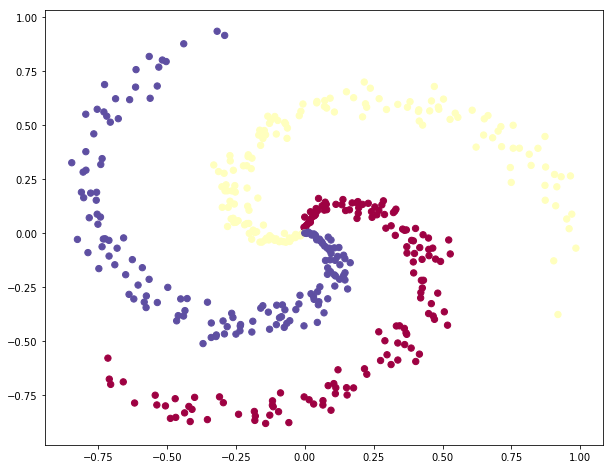

In [27]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import matplotlib.cm as cm

cmap = cm.get_cmap("Spectral")

N = 150 #number of points per class
D = 2 #dims
K = 3 #num classes
X = np.zeros((N*K, D)) #data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') #class labels
for j in range(K):
  ix = range(N*j, N*(j+1))
  r = np.linspace(0.0,1,N)#radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 #theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=cmap)
plt.show()

We have three classes that are non-linearly separable. 

##Training a softmax linear classifier

####Initialize the parameters

Lets first train a softmax classifier. The softmax classifier has a linear score function and uses cross-entropy loss. The parameters consist of a weight matrix W and a bias vector b for each class

In [0]:
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

####Compute the class scores

Since it is a linear classifier we can compute all class scores with a single matrix multiply

In [0]:
scores = np.dot(X, W)+b

We have 300 2-D points, so the scores is size 300 x 3 where each row gives the class scores coresponding to the 3 classes.

####Compute the loss

WE also need a differentiable objective that quantifies our unhappiness with the computed class score. Lets use cross-entropy loss that is associated with the softmax classifier. $f$ is the array of clas scores for a single example, then the softmax computes the loss for that example as:

$L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right)$

We see that softmax classifier interprets every element of $f$ as holding the unnormalized log probabilities of the three classes. We exponeniate these to get unnormalized probabilities, then normalize to get probabilities. The expression inside the log is the normalized probability of the correct class. When the probability of the correct class is small the loss will go towards positive infinity. When the correct classss probability goes towards 1, the loss will go towards zero because $log(1)=0$. Hence, the expression for $L_i$ is low when the correct class probability is high nad its very high when low. 

The full softmax classifier loss is defined as the average cross-entropy loss over the training examples and regularization:

$L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \frac{1}{2} \lambda \sum_k\sum_l W_{k,l}^2 }_\text{regularization loss} \\\\$

Given the array of scoes we can compute the loss. First, to obtain the probabilities is straight forward:



In [0]:
num_examples = X.shape[0]
#get unnorm probs
exp_scores = np.exp(scores)
#norm them for each example
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

We now have array probs of size 300x3. We can now query for the log probabilities assigned to the correct classes in each example:


In [0]:
correct_logprobs = -np.log(probs[range(num_examples), y])

correct logprobs is a 1D array of just probabilities assigned to the correct classes for each example. The full loss is then the average of these log probs and reg:

In [0]:
reg = 1e-3
#compute avg CE loss and reg
data_loss = np.sum(correct_logprobs)/num_examples
reg_loss = 0.5*reg*np.sum(W*W)
loss = data_loss + reg_loss

Reg is multiplied by 0.5 for convenience. Evaluating this might give us loss 1.1 which is np.log(1.0/3), since with small initial random weights all probs assigned to all classes are about one third. We now want to make the loss as small as possible. 

####Computing the Analytic Gradient with Backprop

We now have to minimize the loss. We do so with GD. Start with random params, and evaluate the gradient of the loss w.r.t the params, so that we know how we should change the params to decrease the loss. Lets introduce the intermediate variable $p$, a vector of normalized probs. The loss for one example is:

$p_k = \frac{e^{f_k}}{ \sum_j e^{f_j} } \hspace{1in} L_i =-\log\left(p_{y_i}\right)$

We now want to understand how the computed scores inside $f$ should change to decrease the loss $L_i$. We want to derive the gradient $\partial L_i / \partial f_k$. The loss $L_i$ is computed from $p$, which in turn depends on $f$. It is easy to compute using the chain rule since lots of things cancel out:

$\frac{\partial L_i }{ \partial f_k } = p_k - \mathbb{1}(y_i = k)$

Suppose the probs were p = 0.2, 0.3, 0.5 and the correct class was the middle one 0.3. According to this derivation the gradient on the scores would be df = 0.2, -0.7, 0.5. Increasing the first or last element of the score vector f (the scores of the incorrect classes) leads to an increased loss (due to the positive signs +0.2 and _0.5) - and increasing the loss is bad as expected. However, increasing the score of the correct class has negative influence on the loss. The gradient of -0.7 is telling us that increasing the correct class score would lead to a decrease of the loss $L_i$. 

Recall probs stores the probs of all classes as rows for each example. To get the gradient on the scores which we call dscores:



In [0]:
dscores = probs
dscores[range(num_examples),y] -= 1
dscores /= num_examples

We had that scores = np.dot(X, W) + b, so armed with the gradient on scores stored in dscores we can backpropagate into W and B:

In [0]:
dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
dW += reg*W #regularisation gradient

Where we see that we have backpropped through the matrix multiply operation, and also added the contribution from the regularization. 

Note the reg gradient has a simple form reg*W since we used constant 0.5 for its loss contribution. This simplifies the gradient expression.

####Performing param update

Update in the negative gradient direction to decrease the loss.

In [0]:
step_size = 1e-0
W += -step_size * dW
b += -step_size *db

####Putting it all together


In [28]:
step_size = 1e-0
reg = 1e-3 
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))
num_examples = X.shape[0]
for i in range(200):
  scores = np.dot(X, W) + b
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print("iteration %d: loss %f" % (i, loss))
    
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)
  dW += reg*W
  W += -step_size * dW
  b += -step_size * db

iteration 0: loss 1.097401
iteration 10: loss 0.893428
iteration 20: loss 0.817209
iteration 30: loss 0.781943
iteration 40: loss 0.763167
iteration 50: loss 0.752223
iteration 60: loss 0.745440
iteration 70: loss 0.741049
iteration 80: loss 0.738112
iteration 90: loss 0.736099
iteration 100: loss 0.734693
iteration 110: loss 0.733695
iteration 120: loss 0.732979
iteration 130: loss 0.732459
iteration 140: loss 0.732078
iteration 150: loss 0.731798
iteration 160: loss 0.731591
iteration 170: loss 0.731436
iteration 180: loss 0.731320
iteration 190: loss 0.731233


In [29]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.55


(-1.8812728601742603, 1.918727139825743)

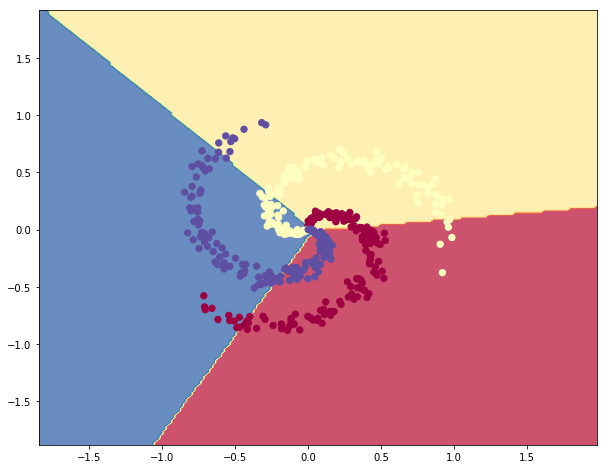

In [30]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

##Training a NN



In [0]:
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

Compute forward pass

In [0]:
hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
scores = np.dot(hidden_layer, W2) + b2

We've now added nonlinearity. Everything ramins the same. Backprop does change however, first backprop the second layer which is identical as before. 

In [0]:
dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

Unlike before, because the hidden layer is a function of other parameters and data, we need to compute backprop through this variable

In [0]:
dhidden = np.dot(dscores, W2.T)

Now we have the gradient on outputs, we backprop the ReLU. This is easy because ReLU during the backward pass is effectively a switch. $r = max(0,x)$ we have that $\frac{dr}{dx} = 1(x > 0)$. Combined with the chain rule, we see that ReLU lets the gradient pass through unchanged if its input was greater than 0 but kills it if its input was less than zero during forward. Hence we can back ReLU simply with

In [0]:
dhidden[hidden_layer <= 0] = 0

Finally continue to the first layer

In [0]:
dW = np.dot(X.T, dhidden)
db = np.sum(dhidden, axis=0, keepdims=True)

Thats it!

In [39]:
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print( "iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098650
iteration 1000: loss 0.350592
iteration 2000: loss 0.257913
iteration 3000: loss 0.246325
iteration 4000: loss 0.242535
iteration 5000: loss 0.240529
iteration 6000: loss 0.239593
iteration 7000: loss 0.239148
iteration 8000: loss 0.238773
iteration 9000: loss 0.238245


In [40]:
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.99


(-1.8812728601742603, 1.918727139825743)

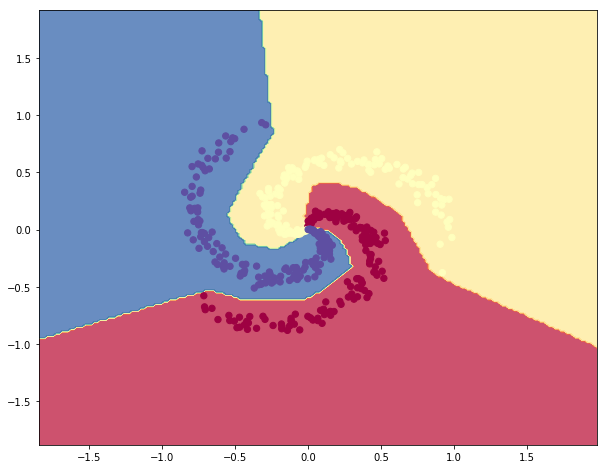

In [41]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')